# A07 Q2: Population Coding

In [147]:
import numpy as np
from Network import *
import math
from matplotlib import pyplot as plt 

# A. `Decoding` Layer

In [148]:
class Encoding(Layer):
    def __init__(self, nodes, dim=1, domain=[-1,1], act=Logistic):
        '''
         enc = Encoding(nodes, dim=1, domain=[-1,1], act=Logistic)
         
         Creates a population for encoding values of dimension dim
         in a chosen domain. The domain specifies what range of values
         to expect to encode.
         
         Inputs:
          nodes   number of neurons in the population
          dim     dimensionality of the encoded data
          domain  set of valid values for encoding
          act     activation function to apply to input currents
          
         Usage:
          enc = Encoding(10, dim=1)
          A = enc([[0.5], [0.9], [-0.2]])
         returns a (3,10) array of neuron activities, and
          B = enc( np.linspace(-1., 1, 100)[:,np.newaxis] )
         returns a (100,10) array regularly sampled from -1 to 1.
        '''
        self.nodes = nodes
        self.dim = dim
        self.domain = domain
        self.act = act()
        self.E = Connection(from_nodes=self.dim, to_nodes=self.nodes, bias='random')
    
    def __call__(self, z):
        return self.act(self.E(z))
    
    
class Decoding(Layer):
    def __init__(self, pre, function):
        '''
         dec = Decoding(pre, function)
         
         Creates a decoding layer that decodes a function from pre.
         
         Inputs:
          pre       the pre-synaptic Encoding layer
          function  the function being decoded
        
         The function must have the calling signature
          function(x)
         where x is a 1D vector (array or list) with dimensions (pre.dim,)
         and returns a 1D array (or list).
         
         Usage:
          dec = Decoding( pre , function=(lambda x: [np.sin(x[0])] ) )
          y = dec(A)  # where A are the activities of the Encoding layer pre
        '''
        self.pre = pre
        self.compute_decoding_weights(function)  # sets self.D
  
    def __call__(self, z):
        return self.D(z)  # self.D is a Connection object
    
    def compute_decoding_weights(self, function):
        '''
         dec.compute_decoding_weights(function)
         
         Computes the optimal linear decoding weights to decode
         the function from values encoded in dec.pre.
        '''
        #===== YOUR CODE HERE =====
        # Choose a bunch of inputs to feed into pre.
        numSample = 1000
        sampleDim = self.pre.dim
        sample = np.random.uniform(low=self.pre.domain[0], high=self.pre.domain[1], size=(numSample,sampleDim))

        # Compute the corresponding targets for those inputs.
        target = np.apply_along_axis(function, 1, sample)
        # Feed those inputs into pre.
        H = self.pre(sample)
        # Solve for the linear decoding weights.
        U, D, V = np.linalg.svd(H)
        m, n = H.shape
        H_reconstructed = U[:,:n] @ np.diag(D) @ V[:m,:]
        weights = V[:m,:].transpose() @ np.linalg.inv(np.diag(D)) @ U[:,:n].transpose() @ target
        # Create the Connection object self.D, and set the weights
        self.D = Connection(from_nodes=self.pre.nodes, to_nodes=target.shape[1], bias='zero')
        self.D.W = weights

# B. Demonstrate 1D encoding/decoding

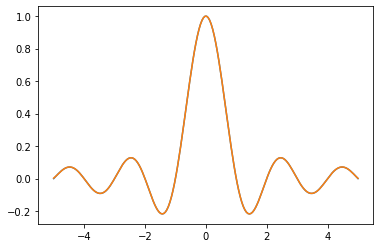

[[ 2.87965537e-03]
 [ 7.64371212e-04]
 [-4.24770840e-04]
 [-9.51168183e-04]
 [-1.03097949e-03]
 [-8.37079846e-04]
 [-5.03334071e-04]
 [-1.29081771e-04]
 [ 2.16274533e-04]
 [ 4.88680120e-04]
 [ 6.64938915e-04]
 [ 7.38413269e-04]
 [ 7.14993940e-04]
 [ 6.09410242e-04]
 [ 4.41935165e-04]
 [ 2.35527615e-04]
 [ 1.34389003e-05]
 [-2.02704743e-04]
 [-3.94345776e-04]
 [-5.46982328e-04]
 [-6.50726347e-04]
 [-7.00474547e-04]
 [-6.95740787e-04]
 [-6.40206934e-04]
 [-5.41054295e-04]
 [-4.08139405e-04]
 [-2.53078713e-04]
 [-8.83045168e-05]
 [ 7.38511615e-05]
 [ 2.21992338e-04]
 [ 3.46373344e-04]
 [ 4.39457134e-04]
 [ 4.96295606e-04]
 [ 5.14720832e-04]
 [ 4.95344911e-04]
 [ 4.41381262e-04]
 [ 3.58304430e-04]
 [ 2.53378116e-04]
 [ 1.35085557e-04]
 [ 1.25013486e-05]
 [-1.05353415e-04]
 [-2.10131515e-04]
 [-2.94716034e-04]
 [-3.53678039e-04]
 [-3.83608434e-04]
 [-3.83303024e-04]
 [-3.53791459e-04]
 [-2.98209228e-04]
 [-2.21523287e-04]
 [-1.30131094e-04]
 [-3.13613814e-05]
 [ 6.70875517e-05]
 [ 1.5773207

In [149]:
# Encode x, and decode sinc(x)
enc = Encoding(20, dim=1,domain=[-5,5])
x = np.linspace(-5., 5., 200)[:,np.newaxis]
targets = np.sinc(x)
A = enc(x)

dec = Decoding(enc, np.sinc)

decoded = dec(A)

plt.plot(x,targets) 
plt.plot(x,decoded)
plt.show()
print(decoded-targets)


In [150]:
# Plot the performance of your network


# C. Demonstrate 2D encoding/decoding

In [151]:
# Create Network that:
# - encodes theta in A -> a
# - decodes (cos(a), sin(a)) and encodes in B -> (b_1, b_2)
# - decodes max(b_1, b_2) -> y
net = Network()
enc1 = Encoding(80, dim=1,domain=[-3.16,3.16], act=LIF)
def decoding1(theta):
    return [math.cos(theta), math.sin(theta)]
dec1 = Decoding(enc1, decoding1)
net.add_layer(enc1)
net.add_layer(dec1)

def decoding2(theta):
    return [np.max(theta)]
enc2 = Encoding(300, dim=2, domain=[-1.5,1.5], act=LIF)
dec2 = Decoding(enc2, decoding2)
net.add_layer(enc2)
net.add_layer(dec2)




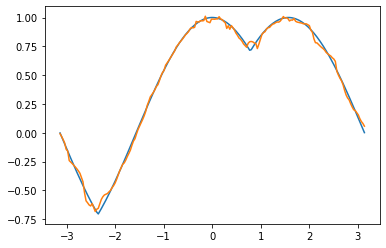

In [152]:
# Plot your network output, and the true function
def getTargets(x):
    return [np.max([np.sin(x), np.cos(x)])]

testInputs =  np.linspace(-3.14, 3.14, 200)[:,np.newaxis]
testTargets = np.apply_along_axis(getTargets, 1, testInputs)
networkOutput = net(testInputs)
plt.plot(testInputs,testTargets) 
plt.plot(testInputs, networkOutput)
plt.show()
